In [221]:
import numpy as np
import pandas as pd
import matplotlib.pylab as plt
%matplotlib inline

x_data = np.linspace(0.0,10.0,1000000)
noise = np.random.randn(len(x_data))

w_data = 0.5
b_data = 5
y_data = w_data*x_data + b_data + noise

x_data_frame = pd.DataFrame(data=x_data,columns=['X data'])
y_data_frame = pd.DataFrame(data=y_data,columns=['Y data'])
all_data_frame = pd.concat([x_data_frame,y_data_frame],axis=1)
all_data_frame.head()

,X data,Y data
0,0.00000,4.572506
1,0.00001,5.913598
2,0.00002,4.709522
3,0.00003,6.075499
4,0.00004,7.868816


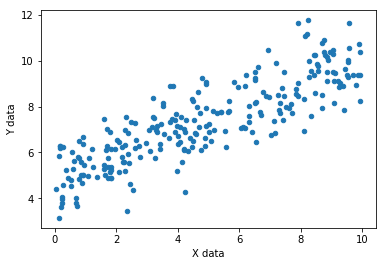

In [148]:
all_data_frame.sample(n=250).plot(kind='scatter',x='X data',y='Y data')

# Tensorflow

In [172]:
import tensorflow as tf
batch_size = 8
w = tf.Variable(0.5)
b = tf.Variable(1.0)
xph = tf.placeholder(tf.float32,[batch_size])
yph = tf.placeholder(tf.float32,[batch_size])

y_model = w*xph + b
error = tf.reduce_sum( tf.square(y_model-yph) )

optimizer = tf.train.GradientDescentOptimizer(learning_rate=0.001)
train = optimizer.minimize(error)

init = tf.global_variables_initializer()
with tf.Session() as sess:
    sess.run(init)
    batches = 1000
    
    for i in range(batches):
        rand_ind = np.arange(i*batch_size,(i+1)*batch_size) # need to check for more than epoch
        feed = {xph:x_data[rand_ind],yph:y_data[rand_ind]}
        sess.run(train,feed_dict=feed)
        
    model_w,model_b = sess.run([w,b])
print('model_w:',model_w)
print('model_b:',model_b)

model_w: 0.518851
model_b: 4.97958


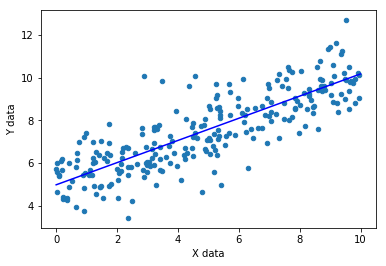

In [178]:
y_hat = model_w * x_data + model_b
all_data_frame.sample(250).plot(kind='scatter',x='X data',y='Y data')
plt.plot(x_data,y_hat,'b')

# tf.estimator API

### 1. split data

In [255]:
from sklearn.model_selection import train_test_split
x_train, x_eval, y_train, y_eval = train_test_split(x_data,y_data,test_size=0.3,random_state=101)

print(x_train.shape)
print(x_eval.shape)
print(y_train.shape)
print(y_eval.shape)

(700000,)
(300000,)
(700000,)
(300000,)


### 2. train data

In [271]:
# x is key, shape has only one dimension. And we have only one feature in this case.
feat_cols = [tf.feature_column.numeric_column('x',shape=[1])] 
estimator = tf.estimator.LinearRegressor(feature_columns=feat_cols)

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': '/var/folders/sr/9k0jqkfs33q22ppyt_t7yjt9716826/T/tmpewlf4yrn', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': None, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x183712c6d8>, '_task_type': 'worker', '_task_id': 0, '_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


In [272]:
print('------- TRAIN -------')
# Train
input_func = tf.estimator.inputs.numpy_input_fn(
    {'x':x_train},
    y_train,
    batch_size=4,
    num_epochs=None,
    shuffle=True)
estimator.train(input_fn=input_func,steps=1000)

------- TRAIN -------
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Saving checkpoints for 1 into /var/folders/sr/9k0jqkfs33q22ppyt_t7yjt9716826/T/tmpewlf4yrn/model.ckpt.
INFO:tensorflow:loss = 195.673, step = 1
INFO:tensorflow:global_step/sec: 1583.86
INFO:tensorflow:loss = 10.0812, step = 101 (0.066 sec)
INFO:tensorflow:global_step/sec: 1858.98
INFO:tensorflow:loss = 5.10195, step = 201 (0.054 sec)
INFO:tensorflow:global_step/sec: 1867.73
INFO:tensorflow:loss = 1.43044, step = 301 (0.054 sec)
INFO:tensorflow:global_step/sec: 1808.78
INFO:tensorflow:loss = 3.29441, step = 401 (0.055 sec)
INFO:tensorflow:global_step/sec: 1850.92
INFO:tensorflow:loss = 6.35149, step = 501 (0.054 sec)
INFO:tensorflow:global_step/sec: 1589.42
INFO:tensorflow:loss = 4.5877, step = 601 (0.062 sec)
INFO:tensorflow:global_step/sec: 1670.92
INFO:tensorflow:loss = 4.34617, step = 701 (0.060 sec)
INFO:tensorflow:global_step/sec: 1727.35
INFO:tensorflow:loss = 4.27894, step = 801 (0.058 sec)
INFO:te

In [266]:
print('------- Evaluate Train Set -------')
# Evaluate train set
train_input_func = tf.estimator.inputs.numpy_input_fn(
    {'x':x_train},
    y_train,
    batch_size=4,
    num_epochs=1000,
    shuffle=False)
train_metrics = estimator.evaluate(input_fn=train_input_func,steps=1000)

------- Evaluate Train Set -------
INFO:tensorflow:Starting evaluation at 2018-02-26-02:48:07
INFO:tensorflow:Restoring parameters from /var/folders/sr/9k0jqkfs33q22ppyt_t7yjt9716826/T/tmp928o4wxn/model.ckpt-1000
INFO:tensorflow:Evaluation [100/1000]
INFO:tensorflow:Evaluation [200/1000]
INFO:tensorflow:Evaluation [300/1000]
INFO:tensorflow:Evaluation [400/1000]
INFO:tensorflow:Evaluation [500/1000]
INFO:tensorflow:Evaluation [600/1000]
INFO:tensorflow:Evaluation [700/1000]
INFO:tensorflow:Evaluation [800/1000]
INFO:tensorflow:Evaluation [900/1000]
INFO:tensorflow:Evaluation [1000/1000]
INFO:tensorflow:Finished evaluation at 2018-02-26-02:48:08
INFO:tensorflow:Saving dict for global step 1000: average_loss = 1.15341, global_step = 1000, loss = 4.61366


In [269]:
print('------- Evaluate Test Set -------')
# Evaluate eval set
eval_input_func = tf.estimator.inputs.numpy_input_fn(
    {'x':x_eval},
    y_eval,
    batch_size=4,
    num_epochs=1000,
    shuffle=False)
eval_metrics = estimator.evaluate(input_fn=eval_input_func,steps=1000)

------- Evaluate Test Set -------
INFO:tensorflow:Starting evaluation at 2018-02-26-02:48:26
INFO:tensorflow:Restoring parameters from /var/folders/sr/9k0jqkfs33q22ppyt_t7yjt9716826/T/tmp928o4wxn/model.ckpt-1000
INFO:tensorflow:Evaluation [100/1000]
INFO:tensorflow:Evaluation [200/1000]
INFO:tensorflow:Evaluation [300/1000]
INFO:tensorflow:Evaluation [400/1000]
INFO:tensorflow:Evaluation [500/1000]
INFO:tensorflow:Evaluation [600/1000]
INFO:tensorflow:Evaluation [700/1000]
INFO:tensorflow:Evaluation [800/1000]
INFO:tensorflow:Evaluation [900/1000]
INFO:tensorflow:Evaluation [1000/1000]
INFO:tensorflow:Finished evaluation at 2018-02-26-02:48:26
INFO:tensorflow:Saving dict for global step 1000: average_loss = 1.14771, global_step = 1000, loss = 4.59085


In [268]:
print("\n *********************************************************")
print("\n ******* See MATRIC to indicate under/over fitting *******")
print("\n *********************************************************")
print("train metrics: ",(train_metrics))
print("eval metrics: {}".format(eval_metrics)) # it's the same as above, I don't know why we have to write this way


 *********************************************************

 ******* See MATRIC to indicate under/over fitting *******

 *********************************************************
train metrics:  {'average_loss': 1.1534146, 'loss': 4.6136584, 'global_step': 1000}
eval metrics: {'average_loss': 1.1477122, 'loss': 4.5908489, 'global_step': 1000}


### 3. predict data

INFO:tensorflow:Restoring parameters from /var/folders/sr/9k0jqkfs33q22ppyt_t7yjt9716826/T/tmpewlf4yrn/model.ckpt-1000
predictions: [array([ 4.37933683], dtype=float32), array([ 10.49108505], dtype=float32)]


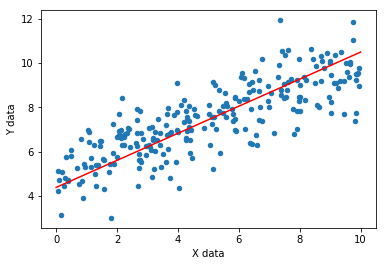

In [276]:
input_fn_predict = tf.estimator.inputs.numpy_input_fn({'x':np.linspace(0,10,2)},shuffle=False)

predictions = []
for p in estimator.predict(input_fn=input_fn_predict):
    predictions.append(p['predictions'])
print('predictions:',predictions)

all_data_frame.sample(n=250).plot(kind='scatter',x='X data',y='Y data')
plt.plot(np.linspace(0,10,2),predictions,'r')